In [1]:
import os
import json
import random
import numpy as np
import pandas as pd

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import itertools
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from itertools import product

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE",
                        "#FFDD00",
                        "#FF7D00",
                        "#FF006D",
                        "#ADFF02",
                        "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


"""
Collection of functions which enable the evaluation of a classifier's performance,
by showing confusion matrix, accuracy, recall, precision etc.
"""

import numpy as np
import sys

import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
import math
import logging
from datetime import datetime
from sklearn.metrics import accuracy_score

def save_history(history, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)

    with open(f"{PATH}/{unique_name}.json", "w+") as f0:
        json.dump(history, f0)

def get_config(file_loc):
    file = torch.load(file_loc)
    return file["model_state_dict"], file["model_config"], file["config"]
    
def save_model(model, model_name, unique_name, models_saves, config):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH, exist_ok=True)
    torch.save({
        "n_epochs": config["n_epochs"],
        "model_state_dict": model.state_dict(),
        "model_config": config["model"],
        "config": config
    }, f"{PATH}/{unique_name}.pt")

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35, print_report=True, show_plot=True):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))
    # print("predicted labels > ", in_pred_labels, "in_true_labels > ", in_true_labels)

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') 

    if show_plot:
        plt.figure()
        plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                                title='Confusion matrix normalized by row')
        plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    if print_report:
        print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    return {"accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [3]:
model_ident = "NTURGB120_skeleton_classifier_10clstest"
unique_iden = "epoch50_emb1024_xy"

main_dir = ".."

data_dir = os.path.join("E:\\FYP_Data\\NTU120\skel\\nturgbd_skeletons_s001_to_s032\\nturgb+d_skeletons")
remove_files = ["E:\\FYP_Data\\NTU120\\skel\\NTU_RGBD120_samples_with_missing_skeletons.txt",
                "E:\\FYP_Data\\NTU120\\skel\\NTU_RGBD_samples_with_missing_skeletons.txt"]

epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
prototypes_save = os.path.join(main_dir,"prototypes")
test_vids = os.path.join(main_dir,"test_vids")
train_ratio = 0.90
val_ratio = 0.1
batch_size = 8

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

with open("E:\\FYP_Data\\NTU120\\skel\\nturgbd_skeletons_s001_to_s032\\nturgb120_label_map.json","r") as f0:
    full_id2cls = json.load(f0)
    
with open("E:\\FYP_Data\\NTU120\\skel\\nturgbd_skeletons_s001_to_s032\\sel_cls_list.txt","r") as f0:
    class_names = [full_id2cls[x] for x in f0.read().split(" ")]

In [4]:
config = {
    "n_epochs":50,
    "model_name":"BidirectionalLSTM",
    "model":{
        "seq_len":50,
        "input_size":25*2,
        "hidden_size":1024,
        "linear_filters":[128,256,512,1024],
        "embedding_size":1024,
        "num_classes":len(class_names),
        "num_layers":1,
        "bidirectional":True,
        "batch_size":batch_size,
        "dev":device
    },
    'alpha_recon': 1,
    'alpha_target': 0.05,
}

id2clsname, clsname2id = classname_id(class_names)

In [5]:
from dataset.SkeletonData.data import *

with open("E:\\FYP_Data\\NTU120\\shapes_keys.json","r") as f0:
    id2shapes = json.load(f0)

files_to_remove = set()
for __f in remove_files:
    with open(__f,"r") as f0:
        for val in f0.read().split("\n"):
            files_to_remove.add(val)

print("Number of Files to remove:= ",len(files_to_remove))

total_files = set([x.split(".")[0] for x in os.listdir(data_dir)]) - files_to_remove
total_files_loc = set([f"{os.path.join(data_dir,x)}.skeleton" for x in total_files])

#split list
rows = [(full_id2cls[str(int(x.split(".")[0][-3:]))],x) for x in total_files_loc]
info_pd = pd.DataFrame(data=rows,columns=["target","file_loc"])

#select needed classes.
info_pd = info_pd.loc[info_pd["target"].isin(class_names)]
train_df, val_df = train_test_split(info_pd,stratify=info_pd["target"],train_size=train_ratio)

print("Number of Files to Total:= ",len(total_files))

train_builder = SkeletonFileBuilder(file_names=set(train_df["file_loc"].to_list()))
val_builder = SkeletonFileBuilder(file_names=set(val_df["file_loc"].to_list()))

print("Number of Files to Train:= ",len(train_builder))
print("Number of Files to Val:= ",len(val_builder))

train_file_iterator = iter(train_builder)
val_file_iterator = iter(val_builder)

Number of Files to remove:=  535
Number of Files to Total:=  113945
Number of Files to Train:=  8513
Number of Files to Val:=  946


In [6]:

def load_file_to_memory(id2shape,save_dict,each_file):
      file_id = each_file.filepath.split(os.path.sep)[-1].split(".")[0]
      num_frame, body_data = each_file.load_data()
      orig_vid_size = id2shape[file_id]
      
      for frame_data in body_data:
        if frame_data["body_count"] != 1:
            return None
      
      skel_data = []
      for frame_data in body_data:
          frame_jd = []
          for jd in frame_data["bodies"][0]["joint_details"]:
              x = jd["colorX"] / orig_vid_size[1]
              y = jd["colorY"] / orig_vid_size[0]

              frame_jd.append([x, y])

          skel_data.append(frame_jd)

      skel_data = np.asarray(skel_data)
      save_dict[file_id] = (file_id,orig_vid_size,str(int(file_id[-3:])),skel_data)
      return file_id

class SkeletonDataset(Dataset):
    def __init__(self,
                 data_builder, 
                 fileid2shape,
                 full_label_map,
                 cls2id,
                 transform=None,
                 seq_len = 100,
                 window_size = 200,
                 target_transform=None,
                 active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],
                 file_name=False, 
                 is_2d=False):
        self.data_builder = data_builder
        self.transform = transform
        self.fileid2shape = fileid2shape
        self.window_size = window_size
        self.seq_len = seq_len
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name
        self.is_2d = is_2d
        self.cls2id = cls2id
        self.full_label_map = full_label_map

        if self.active_locations:
          self.join_translation_map = {k:i for i,k in enumerate(self.active_locations)}
        
        self.data = {}
        with ThreadPoolExecutor() as executor:
          self.indexes = list(
              tqdm(
                executor.map(
                  partial(load_file_to_memory,self.fileid2shape,self.data),
                  self.data_builder), 
                total=len(self.data_builder),
                desc="Loaded Files"
              )
            )
        
        #black_filter = []
        #for idx in range(self.df.shape[0]):
        #  if len(self.data[idx]["coords"].shape)<3 or self.data[idx]["coords"].shape[0]<20:
        #    black_filter.append(idx)
        #
        self.indexes = [x for x in self.indexes if x != None]
    

    def __len__(self):
        return len(self.indexes)
      
    def select_frames(self,sequence):
      if sequence.shape[0]<self.seq_len:
        times = self.seq_len//sequence.shape[0] + 1

        sequence = sequence.repeat(times,1,1)

      if sequence.shape[0]>self.window_size:
        start = random.randint(0,sequence.shape[0]-self.window_size-1)
        sequence = sequence[start:start+self.window_size,...]
                               
      sel_index = sorted(random.sample(range(sequence.shape[0]),self.seq_len))
        
      return sequence[sel_index,...]
    
    def create_connection_map(self,original_map):
      if not self.active_locations:
        return original_map
      
      all_possible_comb = product(self.active_locations,self.active_locations)
      all_possible_comb = set(all_possible_comb)
      
      original_map = set(original_map)
      sel_connections = list(all_possible_comb.intersection(original_map))
      sel_connections = [(self.join_translation_map[x[0]],self.join_translation_map[x[1]]) for x in sel_connections]
      
      return sel_connections 

    def __getitem__(self, idx):
        idx = self.indexes[idx]
        
        orig_target = self.data[idx][2]
        file_path = self.data[idx][0]
        vid_size = self.data[idx][1]
        coords = self.data[idx][3]
        
        target = self.cls2id[self.full_label_map[orig_target]]
        
        if self.active_locations:
          coords = coords[:,self.active_locations,:]

        if self.is_2d:
            coords = coords[...,0:2]

        coords = torch.from_numpy(coords).float()
        coords = self.select_frames(coords)

        shape = coords.shape
        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, target,vid_size,file_path
        return coords, label, target,vid_size

In [7]:
#active_locations=[
#                                 3,2,20,4,5,6,7,8,9,10,11,1,0,12,13,14,16,17,18
#                             ]

In [8]:
train_ds = SkeletonDataset(train_file_iterator,
                             id2shapes,
                             full_id2cls,
                             clsname2id,
                             seq_len=config["model"]["seq_len"],
                             is_2d=True,
                             file_name=True,
                             active_locations=None)
val_ds = SkeletonDataset(val_file_iterator,
                           id2shapes,
                           full_id2cls,
                           clsname2id,
                           seq_len=config["model"]["seq_len"],
                           is_2d=True,
                           file_name=True,
                           active_locations=None)
#test_data = SkeletonDataset(val_file_iterator,id2shapes,is_2d=True)

Loaded Files: 100%|██████████| 946/946 [00:24<00:00, 38.00it/s]


In [9]:
len(train_ds.indexes),len(val_ds.indexes)

(8104, 892)

In [10]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
#test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [11]:
def gen_skeleton(frame, 
                 height,
                 width,
                 mapping_list = [(0, 1), (1, 3), (3, 5), 
                                 (0, 2), (2, 4), (0, 6), 
                                 (1, 7), (6, 7), (6, 8), 
                                 (7, 9), (8, 10), (9, 11)]):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_video(points, 
              save_file, 
              frame_h, 
              frame_w, 
              is_3d=True,
              mapping_list = [(0, 1), (1, 3), (3, 5), 
                                 (0, 2), (2, 4), (0, 6), 
                                 (1, 7), (6, 7), (6, 8), 
                                 (7, 9), (8, 10), (9, 11)]):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        if is_3d:
          fts = points.shape[1]
          x_cds = list(range(0, fts, 3))
          y_cds = list(range(1, fts, 3))
          z_cds = list(range(2, fts, 3))
          points = np.transpose(np.array([points[:, x_cds], 
                                          points[:, y_cds], 
                                          points[:, z_cds]]), (1,2,0))
        else:
          fts = points.shape[1]
          x_cds = list(range(0, fts, 2))
          y_cds = list(range(1, fts, 2))
          points = np.transpose(np.array([points[:, x_cds], 
                                          points[:, y_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, frame_h, frame_w,mapping_list=mapping_list)
        result.write(skel_image)

    result.release()

In [12]:
joint_map = [(3,2),(2,20),(20,4),(4,5),(5,6),(6,7),(7,21),(7,22),(20,8),(8,9),(9,10),(10,11),(11,23),(11,24),
            (20,1),(1,0),(0,12),(12,13),(13,14),(14,15),(0,16),(16,17),(17,18),(18,19)]

joint_map = val_ds.create_connection_map(joint_map)

In [13]:
for adata in tqdm(train_dl):
  selected_ind = random.randint(0,adata[0].shape[0]-1)
  data = adata[0][selected_ind].numpy()
  file_id = adata[4][selected_ind].split(".")[0]
  target = id2clsname[int(adata[2][selected_ind])]
  vid_size = [int(adata[3][0][selected_ind]),int(adata[3][1][selected_ind])]
  
  if(np.isnan(data).sum()):
      print(np.isnan(data).sum(),file_id,"isnan")
      
  if(np.isinf(data).sum()):
    print(np.isinf(data).sum(),file_id,"isinf")
      
  if not (vid_size[0] and vid_size[1]):
    print(vid_size,file_id,"isvidsize")
    

100%|██████████| 1013/1013 [00:05<00:00, 191.90it/s]


In [14]:
"""
save_vids_dir = "checking_vids/init"
for adata in tqdm(train_dl):
  selected_ind = random.randint(0,adata[0].shape[0]-1)
  data = adata[0][selected_ind].numpy()
  file_id = adata[4][selected_ind].split(".")[0]
  target = id2clsname[int(adata[2][selected_ind])]
  vid_size = [int(adata[3][0][selected_ind]),int(adata[3][1][selected_ind])]
  try:
    if not os.path.exists(f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4"):
      os.makedirs(f"{save_vids_dir}/{file_id}",exist_ok=True)
      gen_video(data, 
                f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4",
                vid_size[0], 
                vid_size[1],
                is_3d=False,
                mapping_list=joint_map
                )
  except ValueError:
    continue
"""

'\nsave_vids_dir = "checking_vids/init"\nfor adata in tqdm(train_dl):\n  selected_ind = random.randint(0,adata[0].shape[0]-1)\n  data = adata[0][selected_ind].numpy()\n  file_id = adata[4][selected_ind].split(".")[0]\n  target = id2clsname[int(adata[2][selected_ind])]\n  vid_size = [int(adata[3][0][selected_ind]),int(adata[3][1][selected_ind])]\n  try:\n    if not os.path.exists(f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4"):\n      os.makedirs(f"{save_vids_dir}/{file_id}",exist_ok=True)\n      gen_video(data, \n                f"{save_vids_dir}/{file_id}/dataloader_out_cls_{target}.mp4",\n                vid_size[0], \n                vid_size[1],\n                is_3d=False,\n                mapping_list=joint_map\n                )\n  except ValueError:\n    continue\n'

In [15]:
#!zip -r /content/check_vids.zip /content/checking_vids

In [16]:
class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size,num_classes, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len
        self.num_classes = num_classes

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        self.classification_header = nn.Linear(self.embedding_size,self.num_classes)

        #add embedding out
        if bidirectional:
            self.bn = nn.BatchNorm1d(self.hidden_size*4)
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.bn = nn.BatchNorm1d(self.hidden_size*2)
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)

        #hidden_transformed = self.bn(hidden_transformed)
        hidden_transformed = self.out_linear(hidden_transformed)

        label = self.classification_header(hidden_transformed)
        
        return label, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.linear_filters[0]), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,num_classes, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.num_classes= num_classes
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, num_classes,hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        
    def forward(self,x):
        label,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding, label
        

In [17]:
bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    num_classes = config["model"]["num_classes"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"])

In [18]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=1024, bias=True)
    )
    (classification_header): Linear(in_features=1024, out_features=10, bias=True)
    (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_linear): Linear(in_features=4096, out_features=1024, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=1024, out_features=4096, bias=True)
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): Linear(in_featu

In [19]:
label, embedding =bilstm_model.encoder(torch.randn((
    batch_size,
    config["model"]["seq_len"],
    config["model"]["input_size"])
                                       ).to(device))
embedding.shape,label.shape

(torch.Size([8, 1024]), torch.Size([8, 10]))

In [20]:
label_map = [(k,v) for k,v in id2clsname.items()]
labelToId = {x[0]: i for i, x in enumerate(label_map)}

In [21]:
def combined_loss(pred_sequence,pred_label,true_sequence,true_label,loss_module,alpha_target=1,alpha_recon=1):
    recon_loss = alpha_recon*loss_module["reconstruction_loss"](pred_sequence,true_sequence)
    tar_loss = alpha_target*loss_module["target_loss"](pred_label,true_label)
    loss =  recon_loss + tar_loss

    #print(alpha_recon*loss_module["reconstruction_loss"](pred_sequence,true_sequence))
    #print(alpha_target*loss_module["target_loss"](pred_label,true_label))

    return loss, {
        "reconstruction_loss":recon_loss.item(),
        "target_loss":tar_loss.item()
    }



In [22]:
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=1e-3, weight_decay=0.01)
std_loss = {
    "reconstruction_loss" :nn.L1Loss(),
    "target_loss" :nn.CrossEntropyLoss()
}

In [23]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [24]:
def train_step(model, dataloader, optimizer, loss_module, device, class_names):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    targets = []
    predicts = []

    with tqdm(dataloader, unit="batch", desc="train") as tepoch:
          for input_sequence,target_sequence,target_action,target_vid_size,file_name in tepoch:
            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)
            target_action = target_action.to(device)
            
            input_sequence[torch.isnan(input_sequence)] = 0
            target_sequence[torch.isnan(target_sequence)] = 0

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(True):
            # with autocast():
                predicted_sequence, _, predicted_label  = model(input_sequence)
            
            # loss,loss_detail = combined_loss(predicted_sequence,predicted_label, target_sequence, target_action,std_loss)
            recon_loss = loss_module["reconstruction_loss"](predicted_sequence,target_sequence)
            tar_loss = loss_module["target_loss"](predicted_label,target_action)
            loss =  config['alpha_recon']*recon_loss + config['alpha_target']*tar_loss
            loss_detail = {"reconstruction_loss":recon_loss.item(),"target_loss":tar_loss.item()}

            class_output = torch.argmax(predicted_label,dim=1)

            loss.backward()
            optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(target_action)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=target_action.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

            targets.append(target_action.cpu().detach().numpy())
            predicts.append(pred_class)

    
    predicts = np.concatenate(predicts)
    targets = np.concatenate(targets)
    #train_metrics = action_evaluator(predicts,targets,class_names=list(clsname2id.keys()),print_report=False)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [25]:
def eval_step(model, dataloader,loss_module, device, class_names,  print_report=False, show_plot=False):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'targets': [], 'predictions': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with torch.no_grad():
      with tqdm(dataloader, unit="batch", desc="eval") as tepoch:
        for input_sequence,target_sequence,target_action,target_vid_size,file_name in tepoch:

            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)
            target_action = target_action.to(device)
            
            input_sequence[torch.isnan(input_sequence)] = 0
            target_sequence[torch.isnan(target_sequence)] = 0

            # forward track history if only in train
            with torch.set_grad_enabled(False):
            # with autocast():
                predicted_sequence,_,predicted_label  = model(input_sequence)

            # loss,loss_detail = combined_loss(predicted_sequence,predicted_label, target_sequence, target_action,std_loss)
            recon_loss = loss_module["reconstruction_loss"](predicted_sequence,target_sequence)
            tar_loss = loss_module["target_loss"](predicted_label,target_action)
            loss =  config['alpha_recon']*recon_loss + config['alpha_target']*tar_loss
            loss_detail = {"reconstruction_loss":recon_loss.item(),"target_loss":tar_loss.item()}
            
            pred_action = torch.argmax(predicted_label,dim=1)

            with torch.no_grad():
                metrics['samples'] += len(target_action)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += loss_detail["reconstruction_loss"]
                metrics['classi. loss'] += loss_detail["target_loss"]

            per_batch['targets'].append(target_action.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [26]:
#model_params, model_config, config = get_config("/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/model_saves/temp_HMDB51_skeleton_classifier/100__epoch50_emb1024_xy.pt")
#bilstm_model.load_state_dict(model_params)

In [27]:
torch.cuda.empty_cache()

Training Epoch:   2%|▏         | 1/50 [08:05<6:36:53, 485.99s/it]

Overall accuracy: 0.103



Training Epoch:   4%|▍         | 2/50 [27:39<11:52:27, 890.58s/it]

Overall accuracy: 0.101



Training Epoch:   6%|▌         | 3/50 [51:24<14:48:39, 1134.45s/it]

Overall accuracy: 0.101



Training Epoch:   8%|▊         | 4/50 [1:16:09<16:16:00, 1273.04s/it]

Overall accuracy: 0.101



Training Epoch:  10%|█         | 5/50 [1:40:33<16:46:14, 1341.66s/it]

Overall accuracy: 0.101



Training Epoch:  12%|█▏        | 6/50 [2:05:20<17:00:06, 1391.05s/it]

Overall accuracy: 0.101



Training Epoch:  14%|█▍        | 7/50 [2:30:11<17:00:20, 1423.73s/it]

Overall accuracy: 0.101



Training Epoch:  16%|█▌        | 8/50 [2:54:58<16:50:40, 1443.83s/it]

Overall accuracy: 0.101



Training Epoch:  18%|█▊        | 9/50 [3:16:29<15:54:02, 1396.15s/it]

Overall accuracy: 0.101



eval: 100%|██████████| 112/112 [00:57<00:00,  1.95batch/s, loss=0.163]


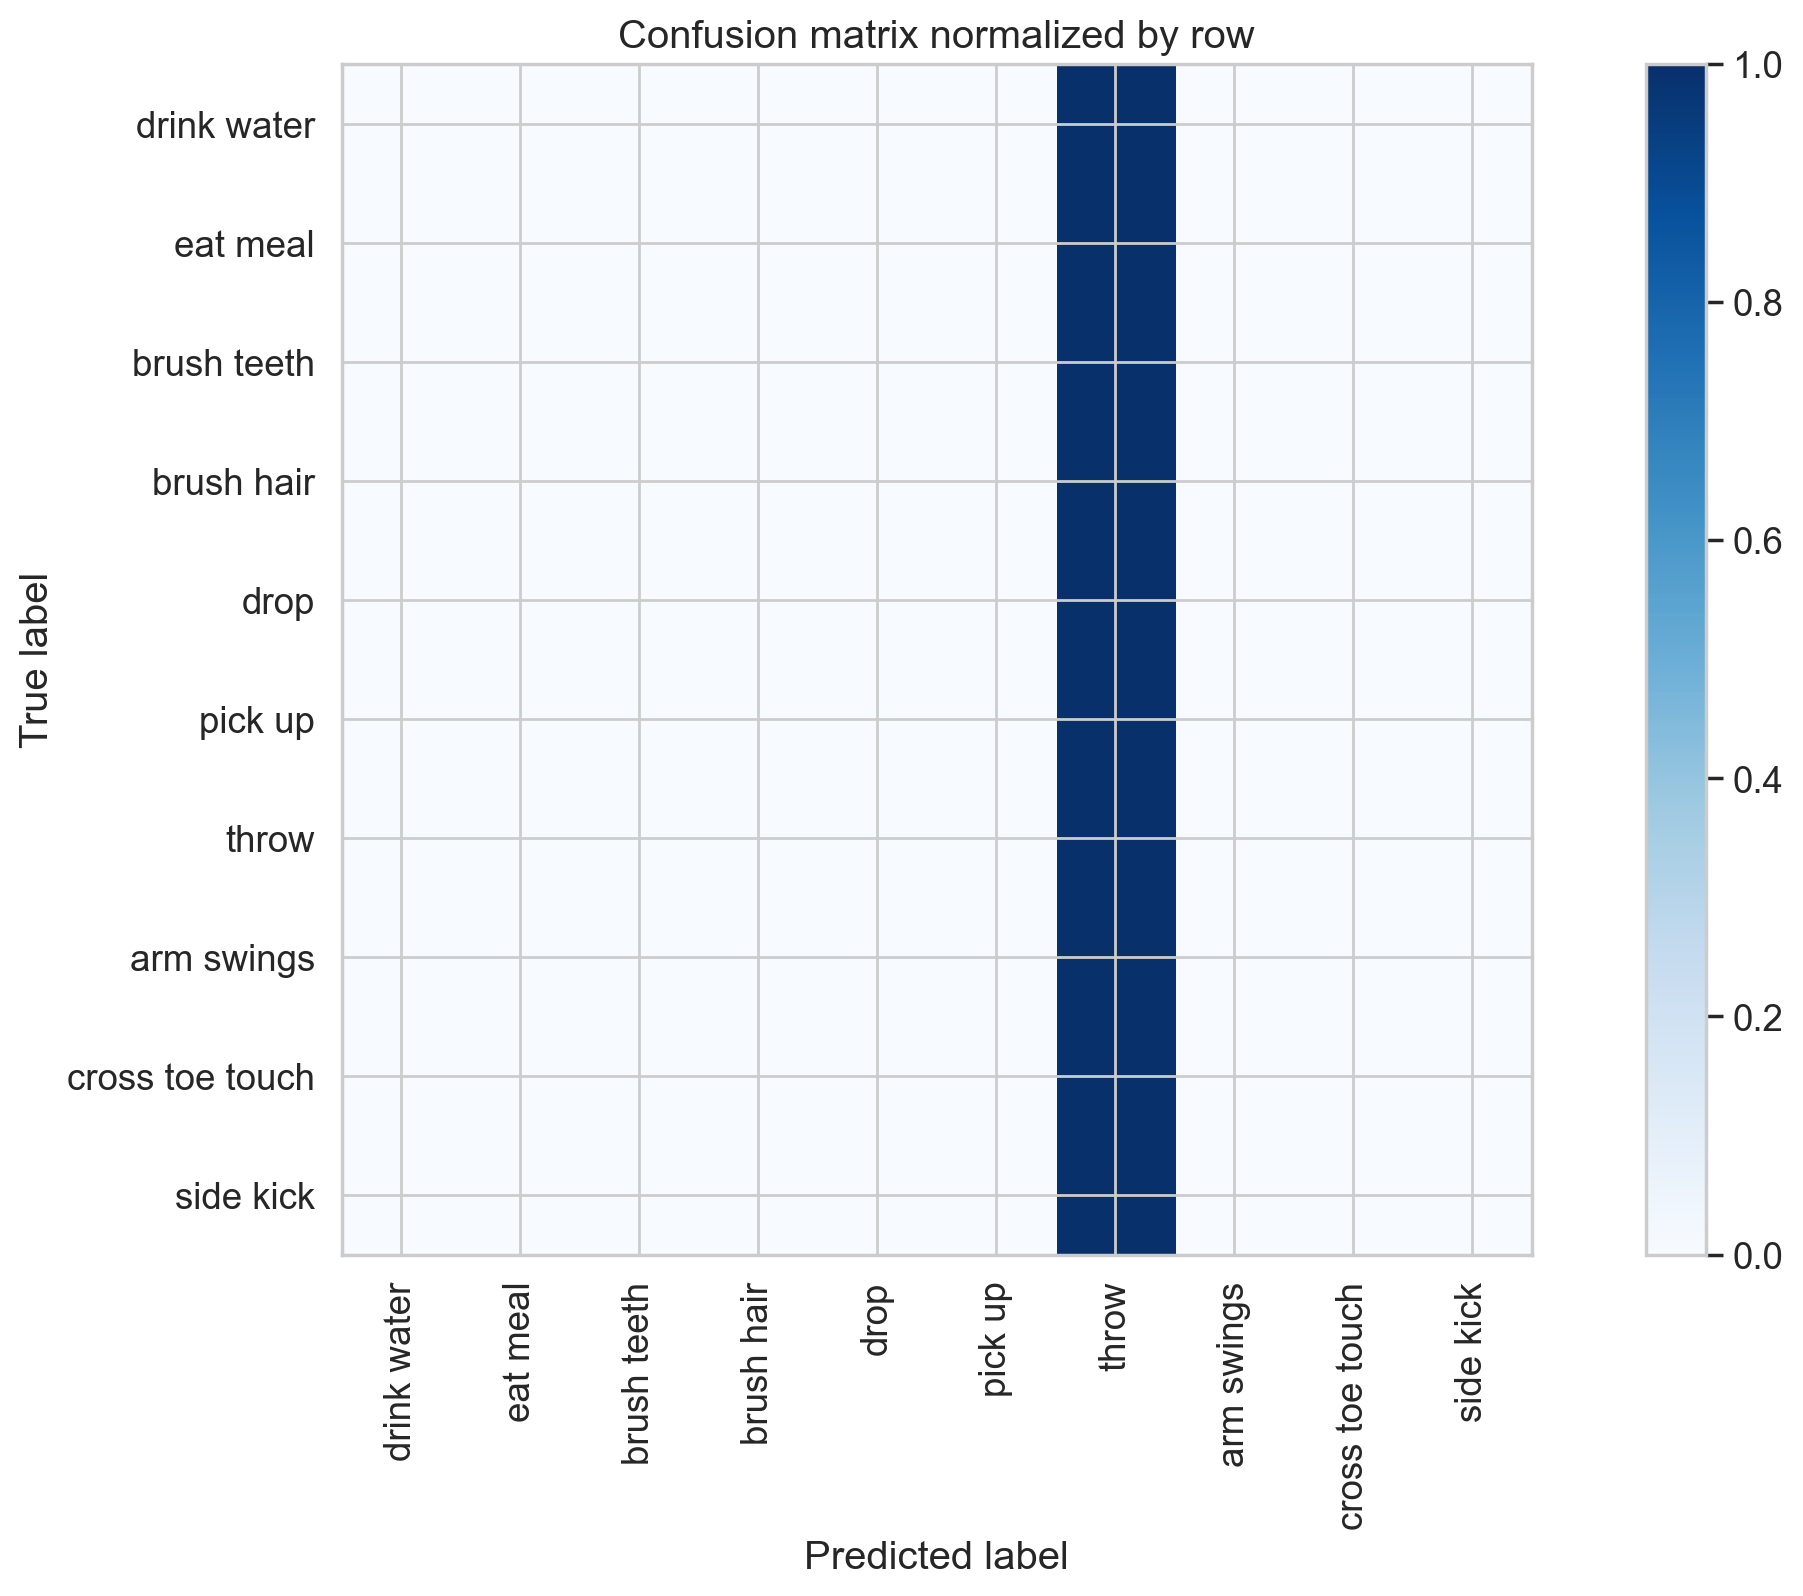

Overall accuracy: 0.101

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        pick up       0.000      0.000      0.000      0.103         92|	 throw: 1.000,	side kick: 0.000,	cross toe touch: 0.000,	
           drop       0.000      0.000      0.000      0.102         91|	 throw: 1.000,	side kick: 0.000,	cross toe touch: 0.000,	
       eat meal       0.000      0.000      0.000      0.102         91|	 throw: 1.000,	side kick: 0.000,	cross toe touch: 0.000,	
          throw       0.101      1.000      0.183      0.101         90|	 side kick: 0.000,	cross toe touch: 0.000,	
     brush hair       0.000      0.000      0.000      0.101         90|	 throw: 1.000,	side kick: 0.000,	cross toe touch: 0.000,	
    brush teeth       0.000      0.000      0.000      0.101         90|	 throw: 1.000,	side kick: 0.000,	cross toe touch: 0.000,	
    drink water       0.000      0.000      0.000      0.100         89|	 throw: 1.000,	side kick: 0.000,	cross 

train:   2%|▏         | 23/1013 [00:17<12:45,  1.29batch/s, loss=0.176, accuracy=0]


KeyboardInterrupt: 

In [28]:
best_model_wts = copy.deepcopy(bilstm_model.state_dict())
best_acc = 0.0
show_interval = 10

train_data = []
for epoch in tqdm(range(1, config["n_epochs"] + 1), desc='Training Epoch', leave=False):
  
  train_metrics = train_step(bilstm_model, train_dl, optimizer, std_loss, device, class_names)
  train_metrics['epoch'] = epoch
  train_metrics['phase'] = 'train'
  train_data.append(train_metrics)
  
  if epoch % 10 == 0:
    eval_metrics = eval_step(bilstm_model, val_dl,std_loss, device, class_names,  print_report=True, show_plot=True)
  else:
    eval_metrics = eval_step(bilstm_model, val_dl,std_loss, device, class_names,  print_report=False, show_plot=False)
  eval_metrics['epoch'] = epoch 
  eval_metrics['phase'] = 'valid'
  train_data.append(eval_metrics)

  if epoch%10 == 0:
    save_model(
        bilstm_model, 
        f"temp_{model_ident}", 
        f"{epoch}__{unique_iden}",
         models_saves, 
         config)
    
  if eval_metrics['accuracy'] > best_acc:
    best_model = copy.deepcopy(bilstm_model.state_dict())
  
train_df = pd.DataFrame().from_records(train_data)
plot_curves(train_df)

# replace by best model 
bilstm_model.load_state_dict(best_model)



